In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_wine
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA
import pandas as pd
import requests
import json
import plotly.express as px
import prettytable

sns.set()
sns.set_style('darkgrid')

In [19]:
fips_url = "https://www2.census.gov/geo/docs/reference/codes/files/national_county.txt"
fips_data = requests.get(fips_url)
fips_data = fips_data.content.decode('UTF-8').split('\r\n')
fips_data.pop()
fips_index = []
for i, row in enumerate(fips_data):
  fips_data[i] = row.split(',')[:2]
  fips_index.append(fips_data[i][1])
fips_data = pd.DataFrame(fips_data, columns=['state_abbr', 'state_fips'], index=pd.to_numeric(fips_index))
fips_data.drop_duplicates(inplace=True)
fips_data.dropna(inplace=True)
fips_data.drop(index=[11, 60, 66, 69, 72, 74, 78], inplace=True)
fips_data.head()

,state_abbr,state_fips
1,AL,01
2,AK,02
4,AZ,04
5,AR,05
6,CA,06


In [22]:
crime_url = 'https://api.usa.gov/crime/fbi/sapi/api/estimates/states/{}/{}/{}?API_KEY={}'
api_key = 'A3Ldfo0xnPlv5lhooEivEXqk3v8twOrFVJhuJIbb'
start_date = '2020'
end_date = '2020'
crime_data = pd.DataFrame()
for i in fips_data.index:
  try:
    f = requests.get(crime_url.format(fips_data['state_abbr'][i], start_date, end_date, api_key))
    j = json.loads(f.content)['results'][0]
    d = pd.DataFrame(data=j, index=[i])
    crime_data = pd.concat([crime_data, d])
  except BaseException as e:
    print(e)
crime_data.drop(['state_id', 'rape_legacy'], axis=1, inplace=True)
crime_data = crime_data.assign(per_capita_vc=crime_data['violent_crime'] / crime_data['population'] * 100)
crime_data = crime_data.assign(per_capita_homicide=crime_data['homicide'] / crime_data['population'] * 100)
crime_data.head()

   state_abbr  year  population  violent_crime  homicide  rape_revised  \
1          AL  2020     4921532          22322       471          1608   
2          AK  2020      731158           6126        49          1132   
4          AZ  2020     7421401          35980       513          3263   
5          AR  2020     3030522          20363       321          2226   
6          CA  2020    39368078         174026      2203         13449   
8          CO  2020     5807719          24570       294          3652   
9          CT  2020     3557006           6459       140           594   
10         DE  2020      986809           4262        73           261   
12         FL  2020    21733312          83368      1290          7686   
13         GA  2020    10710017          42850       943          3420   
15         HI  2020     1407006           3576        41           569   
16         ID  2020     1826913           4432        41           832   
17         IL  2020    12587530       

In [23]:
pov_url = 'https://api.census.gov/data/timeseries/poverty/saipe?get=NAME,SAEMHI_PT,SAEMHI_MOE,SAEPOVALL_PT,SAEPOVALL_MOE,SAEPOVRTALL_PT,SAEPOVRTALL_MOE&for=state:{}&YEAR={}'
date = '2020'
pov_data = pd.DataFrame()
for f in fips_data['state_fips']:
  r = requests.get(pov_url.format(f, date))
  if r.content != b'':
    s = str(r.content, 'utf8').split(',\n')
    for i, n in enumerate(s):
      s[i] = n.replace('[','').replace(']', '').replace('"', '').split(',')
    pov_data = pd.concat([pov_data, pd.DataFrame(data=[s[1][1:]], columns=['median income estimate', 'mie margin of error', 'all ages in poverty', 'aaip margin of error', 'poverty rate', 'pr margin of error', 'year', 'state'], index=[int(f)], dtype='float')])
pov_data.drop(['state', 'year'], axis=1, inplace=True)
pov_data.head()

,median income estimate,mie margin of error,all ages in poverty,aaip margin of error,poverty rate,pr margin of error
1,53958.0,945.0,714568.0,19319.0,14.9,0.4
2,79961.0,2430.0,68714.0,3762.0,9.6,0.5
4,64652.0,917.0,932555.0,28428.0,12.8,0.4
5,51146.0,1396.0,448665.0,13767.0,15.2,0.5
6,83001.0,579.0,4419167.0,61722.0,11.5,0.2


In [26]:
headers = {'Content-type': 'application/json'}
employment_data = {}

# Number of workers by thousands
state_employment = []
for s in fips_data['state_fips']:
  state_employment.append('SMU' + s + '000000000000001')


data = json.dumps({"seriesid": state_employment,"startyear":"2020", "endyear":"2020", "registrationkey": "9d4bf9ff6a5849a792c0e46ad30c7d4a"})
p = requests.post('https://api.bls.gov/publicAPI/v2/timeseries/data/', data=data, headers=headers)
employment_data = json.loads(p.text)

In [29]:
for x in employment_data['Results']['series']:
  print(x)

{'seriesID': 'SMU01000000000000001', 'data': [{'year': '2020', 'period': 'M12', 'periodName': 'December', 'value': '2040.3', 'footnotes': [{}]}, {'year': '2020', 'period': 'M11', 'periodName': 'November', 'value': '2032.8', 'footnotes': [{}]}, {'year': '2020', 'period': 'M10', 'periodName': 'October', 'value': '2021.1', 'footnotes': [{}]}, {'year': '2020', 'period': 'M09', 'periodName': 'September', 'value': '1992.1', 'footnotes': [{}]}, {'year': '2020', 'period': 'M08', 'periodName': 'August', 'value': '1981.8', 'footnotes': [{}]}, {'year': '2020', 'period': 'M07', 'periodName': 'July', 'value': '1959.1', 'footnotes': [{}]}, {'year': '2020', 'period': 'M06', 'periodName': 'June', 'value': '1947.5', 'footnotes': [{}]}, {'year': '2020', 'period': 'M05', 'periodName': 'May', 'value': '1895.5', 'footnotes': [{}]}, {'year': '2020', 'period': 'M04', 'periodName': 'April', 'value': '1844.6', 'footnotes': [{}]}, {'year': '2020', 'period': 'M03', 'periodName': 'March', 'value': '2073.6', 'foot

In [40]:
# Avg yearly earnings for all employees in dollars
state_weekly_earnings = []
for s in fips_data['state_fips']:
  state_weekly_earnings.append('ENU' + s + '00050010')
data = json.dumps({"seriesid": state_weekly_earnings,"startyear":"2020", "endyear":"2020", "registrationkey": "9d4bf9ff6a5849a792c0e46ad30c7d4a"})
p = requests.post('https://api.bls.gov/publicAPI/v2/timeseries/data/', data=data, headers=headers)
weekly_earnings_data = json.loads(p.text)
print(weekly_earnings_data)

{'status': 'REQUEST_SUCCEEDED', 'responseTime': 797, 'message': [], 'Results': {'series': [{'seriesID': 'ENU0100050010', 'data': [{'year': '2020', 'period': 'A01', 'periodName': 'Annual', 'value': '52210', 'footnotes': [{}]}]}, {'seriesID': 'ENU0200050010', 'data': [{'year': '2020', 'period': 'A01', 'periodName': 'Annual', 'value': '61730', 'footnotes': [{}]}]}, {'seriesID': 'ENU0400050010', 'data': [{'year': '2020', 'period': 'A01', 'periodName': 'Annual', 'value': '58426', 'footnotes': [{}]}]}, {'seriesID': 'ENU0500050010', 'data': [{'year': '2020', 'period': 'A01', 'periodName': 'Annual', 'value': '48672', 'footnotes': [{}]}]}, {'seriesID': 'ENU0600050010', 'data': [{'year': '2020', 'period': 'A01', 'periodName': 'Annual', 'value': '79480', 'footnotes': [{}]}]}, {'seriesID': 'ENU0800050010', 'data': [{'year': '2020', 'period': 'A01', 'periodName': 'Annual', 'value': '66649', 'footnotes': [{}]}]}, {'seriesID': 'ENU0900050010', 'data': [{'year': '2020', 'period': 'A01', 'periodName': 

In [46]:
# Unemployment rate
state_unemp = []
for s in fips_data['state_fips']:
  state_unemp.append('LAUST' + s + '0000000000003')
data = json.dumps({"seriesid": state_unemp,"startyear":"2020", "endyear":"2020", "registrationkey": "9d4bf9ff6a5849a792c0e46ad30c7d4a"})
p = requests.post('https://api.bls.gov/publicAPI/v2/timeseries/data/', data=data, headers=headers)
unemp_json = json.loads(p.text)

In [47]:
unemp_data = pd.DataFrame()
for s in unemp_json['Results']['series']:
  unemp_data = pd.concat([unemp_data, pd.DataFrame(s)])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


TypeError: ignored

In [ ]:
all_data = pd.merge(fips_data, crime_data, left_index=True, right_index=True)
all_data = pd.merge(all_data, pov_data, left_index=True, right_index=True)
all_data.rename(columns={'state_abbr_x': 'state_abbr'}, inplace=True)
all_data.drop(columns='state_abbr_y', inplace=True)
all_data.head()

,state_abbr,state_fips,year,population,violent_crime,homicide,rape_revised,robbery,aggravated_assault,property_crime,...,motor_vehicle_theft,arson,per_capita_vc,per_capita_homicide,median income estimate,mie margin of error,all ages in poverty,aaip margin of error,poverty rate,pr margin of error
1,AL,01,2020,4921532,22322,471,1608,2666,17577,105161,...,10926,34,0.453558,0.009570,53958.0,945.0,714568.0,19319.0,14.9,0.4
2,AK,02,2020,731158,6126,49,1132,712,4233,16528,...,1969,140,0.837849,0.006702,79961.0,2430.0,68714.0,3762.0,9.6,0.5
4,AZ,04,2020,7421401,35980,513,3263,6211,25993,165323,...,17937,1279,0.484814,0.006912,64652.0,917.0,932555.0,28428.0,12.8,0.4
5,AR,05,2020,3030522,20363,321,2226,1577,16239,79200,...,7933,556,0.671930,0.010592,51146.0,1396.0,448665.0,13767.0,15.2,0.5
6,CA,06,2020,39368078,174026,2203,13449,44728,113646,842054,...,168323,11761,0.442049,0.005596,83001.0,579.0,4419167.0,61722.0,11.5,0.2


'pov_states = pd.DataFrame()\nfor s in pov_data[\'state\']:\n  pov_states = pd.concat([pov_states, fips_data.loc[pd.to_numeric(fips_data[\'state_fips\']) == s][[\'state_abbr\', \'state_fips\']]])\nfig = px.choropleth(data_frame=pov_data, locations=pov_states[\'state_abbr\'].unique(), locationmode="USA-states", color=\'SAEPOVRTALL_PT\', scope="usa",  color_continuous_scale=["#FFFFFF", "#FF1053"])\nfig.update_geos(visible=False)\nfig.show()'

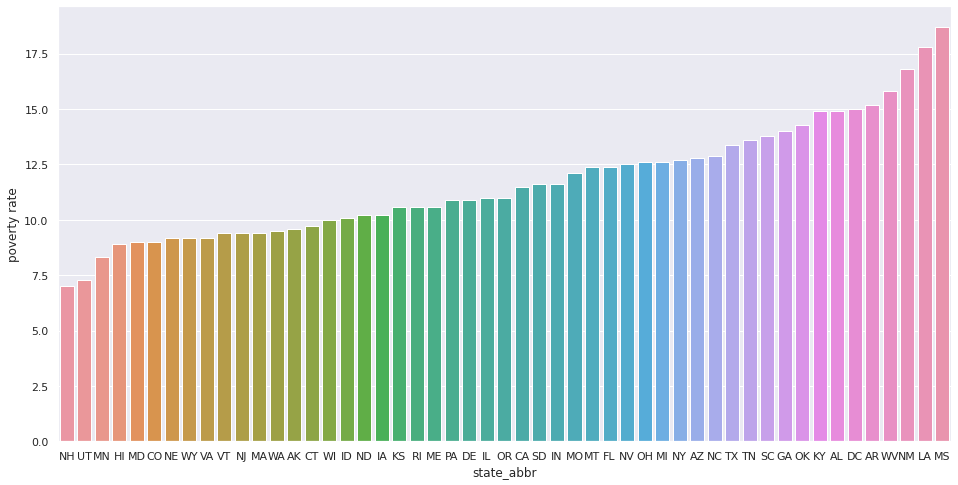

In [ ]:
all_data.sort_values(by=['poverty rate'], inplace=True)
fig = plt.figure(figsize=(16,8))
fig = sns.barplot(data=all_data, x='state_abbr', y='poverty rate')

"""pov_states = pd.DataFrame()
for s in pov_data['state']:
  pov_states = pd.concat([pov_states, fips_data.loc[pd.to_numeric(fips_data['state_fips']) == s][['state_abbr', 'state_fips']]])
fig = px.choropleth(data_frame=pov_data, locations=pov_states['state_abbr'].unique(), locationmode="USA-states", color='SAEPOVRTALL_PT', scope="usa",  color_continuous_scale=["#FFFFFF", "#FF1053"])
fig.update_geos(visible=False)
fig.show()"""

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



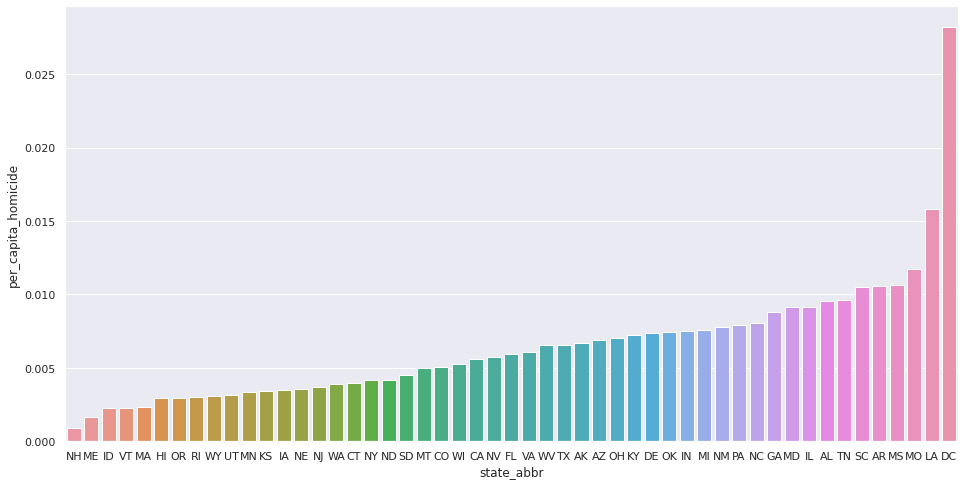

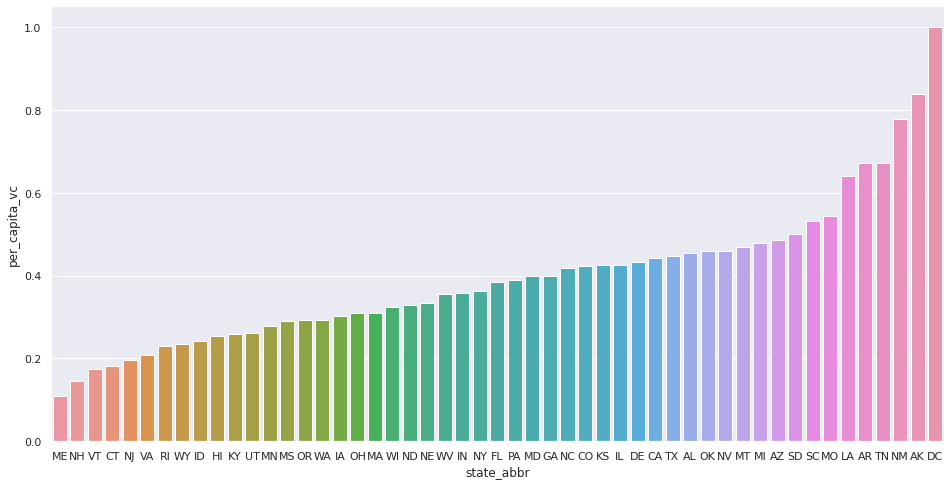

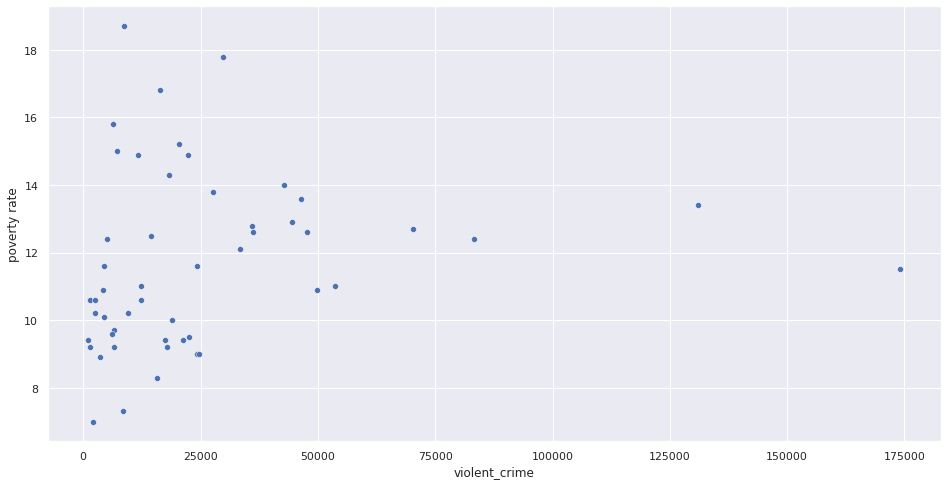

In [ ]:
fig2 = px.choropleth(data_frame=all_data, locations='state_abbr', locationmode="USA-states", color='per_capita_vc', scope="usa",  color_continuous_scale=["#FFFFFF", "#FF1053"])
fig2.update_geos(visible=False)
fig2.show()
all_data.sort_values(by='per_capita_homicide', inplace=True)
fig3 = plt.figure(figsize=(16,8))
sns.barplot(all_data['state_abbr'], all_data['per_capita_homicide'])
all_data.sort_values(by='per_capita_vc', inplace=True)
fig4 = plt.figure(figsize=(16,8))
sns.barplot(all_data['state_abbr'], all_data['per_capita_vc'])
fig5 = plt.figure(figsize=(16, 8))
sns.scatterplot(all_data['violent_crime'], all_data['poverty rate'])

ME 0
NH 0
VT 0
CT 0
NJ 0
VA 0
RI 0
WY 0
ID 0
HI 0
KY 0
UT 0
MN 0
MS 0
OR 0
WA 0
IA 0
OH 0
MA 0
WI 0
ND 0
NE 0
WV 1
IN 1
NY 1
FL 1
PA 1
MD 1
GA 1
NC 1
CO 1
KS 1
IL 1
DE 1
CA 1
TX 1
AL 1
OK 1
NV 1
MT 1
MI 1
AZ 1
SD 1
SC 1
MO 1
LA 2
AR 2
TN 2
NM 2
AK 2
DC 2


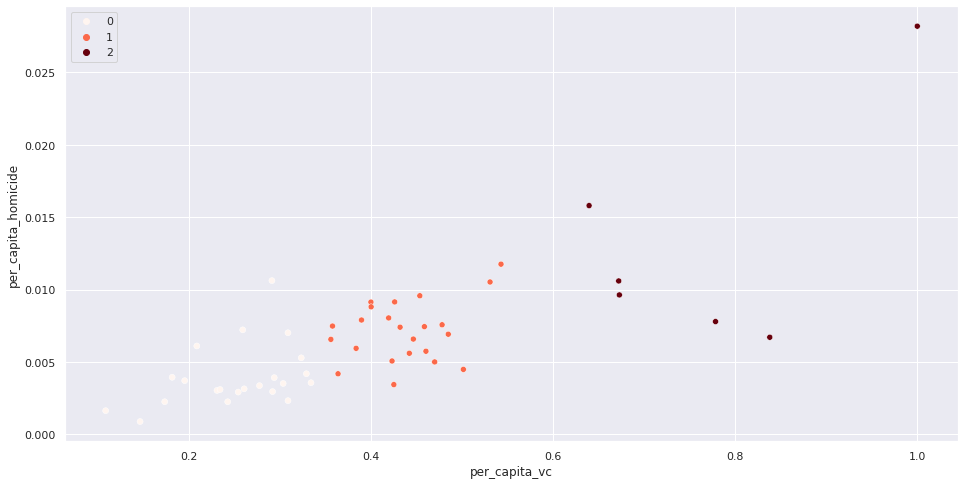

In [ ]:
train_data, test_data = train_test_split(pc)
model = KMeans(n_clusters=3)
km = model.fit(train_data[['per_capita_vc', 'per_capita_homicide']])
predict = km.predict(pc[['per_capita_vc', 'per_capita_homicide']])
plt.figure(figsize=(16,8))
sns.scatterplot(x=pc['per_capita_vc'], y=pc['per_capita_homicide'], hue=predict, palette='Reds')
for i, s in enumerate(pc['state_abbr']):
  print(s, predict[i])

In [ ]:
sns.factorplot(x='class', y='survival rate', hue='sex', data=df, kind='bar')